In [204]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark")  

In [3]:
# get the data 

!wget -nc https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv

--2024-04-05 17:17:50--  https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1598 (1.6K) [text/csv]
Saving to: 'perrin-freres-monthly-champagne.csv'

perrin-freres-month 100%[===================>]   1.56K  --.-KB/s    in 0s      

2024-04-05 17:17:51 (6.74 MB/s) - 'perrin-freres-monthly-champagne.csv' saved [1598/1598]



In [206]:
df = pd.read_csv('perrin-freres-monthly-champagne.csv')


In [207]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [208]:
df.isna()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
102,False,False
103,False,False
104,False,False
105,True,True


In [209]:
df.isna().sum()

Month                                                     1
Perrin Freres monthly champagne sales millions ?64-?72    2
dtype: int64

In [210]:
# last two rows have NA columns that we will drop
df.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [211]:
df = df.dropna()

df.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
100,1972-05,4618.0
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0


In [212]:
# rename the sales column 
df.rename(columns={'Perrin Freres monthly champagne sales millions ?64-?72': 'Champagne_Sales'}, inplace=True)

df.head()

,Month,Champagne_Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Month            105 non-null    object 
 1   Champagne_Sales  105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.5+ KB


In [214]:
# Month column has a dtype of 'object', we will turn it into date time and make it as the index column for the time-series

df['Month'] = pd.to_datetime(df['Month'])

df.set_index('Month', inplace=True)

df.head()

,Champagne_Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [215]:
df.index

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', name='Month', length=105, freq=None)

In [216]:
# set the frequency of the index to 'MS'

df.index.freq = 'MS'

In [217]:
df.index

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', name='Month', length=105, freq='MS')

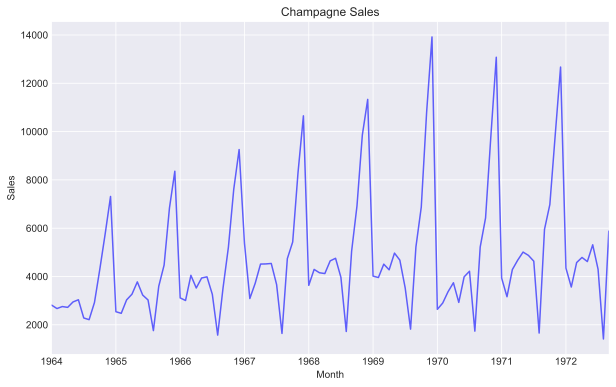

In [218]:
fig, axis = plt.subplots(figsize = (10,6))

df['Champagne_Sales'].plot(ax = axis, color = 'blue', alpha = 0.6)

axis.set_ylabel('Sales')
axis.set_title('Champagne Sales')

axis.grid()

The seasonal pattern within a calender year is clearly visible. There seem to be a increase in the peaks of the seasonal increase in the sales as well, at leat up to a certain year. 

In [219]:
# train-test split 

N_test = 12 # last 12 months as the test set 

train = df[:-N_test]
test = df[-N_test:]

In [221]:
# boolean series to slice the data horizontally for train and test

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [222]:
# Initiate the Holt-winters and train 

hw = ExponentialSmoothing(train['Champagne_Sales'], initialization_method='legacy-heuristic', trend='add', seasonal='add', seasonal_periods=12)

result_hw = hw.fit()

result_hw.summary()

Dep. Variable:,Champagne_Sales,No. Observations:,93
Model:,ExponentialSmoothing,SSE,47208168.850
Optimized:,True,AIC,1253.785
Trend:,Additive,BIC,1294.307
Seasonal:,Additive,AICC,1263.029
Seasonal Periods:,12,Date:,"Fri, 05 Apr 2024"
Box-Cox:,False,Time:,20:52:17
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0757143,alpha,True
smoothing_trend,0.0001,beta,True


In [223]:
# Insert the predictions as a new column 
df.loc[train_idx, 'HW_MS_Pred'] = result_hw.fittedvalues
df.loc[test_idx, 'HW_MS_Pred'] = result_hw.forecast(N_test)

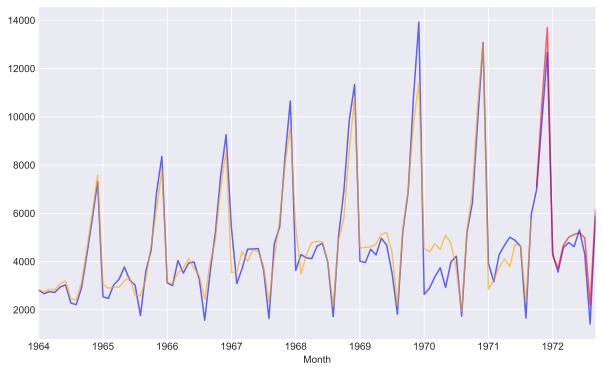

In [224]:
# Plot the predictions 

fig, axis = plt.subplots(figsize = (10,6))

df['Champagne_Sales'].plot(ax = axis, color = 'blue', alpha = 0.6)

df.loc[train_idx, 'HW_MS_Pred'].plot(ax = axis, color = 'orange', alpha = 0.6)
df.loc[test_idx, 'HW_MS_Pred'].plot(ax = axis, color = 'red', alpha = 0.6)

axis.grid()


It is a reasonable fit however, the model is having a hard time to fit to the peaks, especially when the peaks are dramatic in the training set. 

In [225]:
train_pred = result_hw.fittedvalues
test_pred = result_hw.forecast(N_test)

rmse_train = mean_squared_error(train['Champagne_Sales'], train_pred, squared = False)
rmse_test = mean_squared_error(test['Champagne_Sales'], test_pred, squared = False)

r2_train = r2_score(train['Champagne_Sales'], train_pred)
r2_test = r2_score(test['Champagne_Sales'], test_pred)

print(f'RMSE on the training and test sets are: {rmse_train:.2f} and {rmse_test:.2f}')
print(f'R^2 score on the training and test sets are: {r2_train:.2f} and {r2_test:.2f}')

RMSE on the training and test sets are: 712.47 and 509.97
R^2 score on the training and test sets are: 0.92 and 0.97


As we realized before the fact that $R^2$ score is lower in the training set is because the model can not accurately capture the peaks in the training set while it performs better in the test set. This is obviously reflected in the ${\rm RMSE}$ as well. 

In [227]:
# Lets do walk forward validation to find the best model parameters 

# first drop the Predictions column 

df = df.drop(columns='HW_MS_Pred', axis = 1)

df.head()

,Champagne_Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 1964-01-01 to 1972-09-01
Freq: MS
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Champagne_Sales  105 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


In [233]:
col = df.columns.to_list()[0]

'Champagne_Sales'

In [255]:

# Forecast horizon we care about is 12
# validate each model over 10 steps 

h = 12
steps = 10

Ntest = len(df) - (h + steps) + 1 #the effective validation period 

In [257]:
df.tail()

,Champagne_Sales
Month,
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0
1972-08-01,1413.0
1972-09-01,5877.0


In [258]:
df.iloc[94:106]

,Champagne_Sales
Month,
1971-11-01,9851.0
1971-12-01,12670.0
1972-01-01,4348.0
1972-02-01,3564.0
1972-03-01,4577.0
1972-04-01,4788.0
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0


In [263]:
# Different hyperparameters to try

trend_type_list = ['add', 'mul']

season_type_list = ['add', 'mul']

#damped_trend_list = [True, False]

init_method_list = ['estimated', 'heuristic', 'legacy-heuristic']

use_boxcox_list = [True, False, 0]

In [264]:
def walk_forward(trend_type, season_type, init_method, use_boxcox, debug=False):

    #store errors

    errors = list()
    #r2_scores = list()
    
    # to check if we have seen the last data point in the whole data set
    seen_last = False

    # to check if we went through all the walk forward steps
    steps_completed = 0

    for end_of_train in range(Ntest, len(df)-h+1):
        
        train = df.iloc[:end_of_train]
        test = df.iloc[end_of_train:end_of_train+h]

        if test.index[-1] == df.index[-1]:

            seen_last = True
        
        steps_completed += 1

        hw = ExponentialSmoothing(train['Champagne_Sales'],
                                   initialization_method=init_method,
                                    trend = trend_type,
                                    seasonal = season_type,
                                    seasonal_periods=12,
                                    use_boxcox=use_boxcox)
        res_hw = hw.fit()

        # compute test errors for the forecast horizon h

        fcast = res_hw.forecast(h)
        mse = mean_squared_error(test['Champagne_Sales'],fcast)
        #r2 = r2_score(test,fcast)
        errors.append(mse)
        #r2_scores.append(r2)

    if debug:

        print('seen_last:', seen_last)
        print('steps_completed:', steps_completed)

    return np.mean(errors) #print(f"Mean RMSE on the test set is: {np.mean(errors):.2f}")

In [265]:
# test the function

walk_forward('add','mul','legacy-heuristic', True, debug = True)

seen_last: True
steps_completed: 10


970942.2939233988

In [266]:
# Create tuples that contain all possible model parameter combinations 

import itertools

tuple_of_option_lists = (trend_type_list,season_type_list,init_method_list,use_boxcox_list)

best_score = float('inf')
best_option = None

for x in itertools.product(*tuple_of_option_lists):

    score = walk_forward(*x)

    if score < best_score:

        print('Best score so far:', score)

        best_score = score
        best_option = x

Best score so far: 206033.7198253627
Best score so far: 199800.47163279232


/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed

Best score so far: 198673.59098532217


/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/l

In [269]:
print('Best score:', np.sqrt(best_score))

Best score: 445.7281581696653


In [270]:
best_trend, best_season, best_init, best_boxcox = best_option

print("optimal trend type:", best_trend)
print("optimal seasonality type:", best_season)
print("optimal initilization method:", best_init)
print("optimal box-cox option:", best_boxcox)

optimal trend type: mul
optimal seasonality type: add
optimal initilization method: heuristic
optimal box-cox option: True


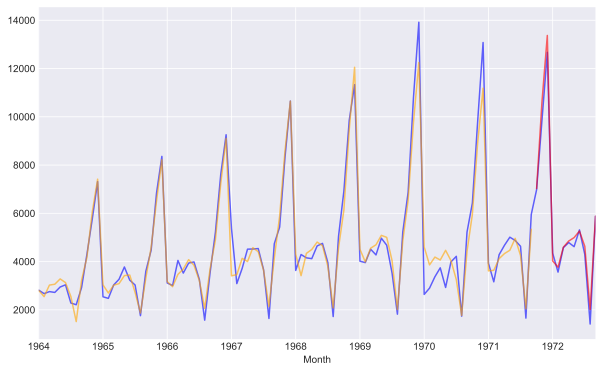

In [272]:
# train-test split 

N_test = 12 # last 12 months as the test set 

train = df[:-N_test]
test = df[-N_test:]

# boolean series to slice the data horizontally for train and test

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

# Initiate the Holt-winters and train 

hw_b = ExponentialSmoothing(train['Champagne_Sales'], initialization_method='heuristic', trend='mul', seasonal='add', seasonal_periods=12, use_boxcox=True)

result_hw_b = hw_b.fit()

# Insert the predictions as a new column 
df.loc[train_idx, 'HW_MS_bPred'] = result_hw_b.fittedvalues
df.loc[test_idx, 'HW_MS_bPred'] = result_hw_b.forecast(N_test)

# Plot the predictions 

fig, axis = plt.subplots(figsize = (10,6))

df['Champagne_Sales'].plot(ax = axis, color = 'blue', alpha = 0.6)

df.loc[train_idx, 'HW_MS_bPred'].plot(ax = axis, color = 'orange', alpha = 0.6)
df.loc[test_idx, 'HW_MS_bPred'].plot(ax = axis, color = 'red', alpha = 0.6)

axis.grid()